In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.Q_BAI import Q_SAR, uniform_sampling, Q_UGapEb, Q_SAR_Simplified, batch_elimination
from codes.Mean_BAI import UGapEb, SAR_Simplified
from codes.Environment import Mixture_AbsGau, setup_env, Exp
from codes.SimulatedGames import simulate, simulate_mean
from codes.plots import plot_hist, plot_eva, plot_eva_m

%matplotlib inline

In [2]:
# environment

environments = [
    {Mixture_AbsGau: [[0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1],  
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1],
                     ],
     Exp: [[1/4], [1/4]
          ]
    } # mu1, sigma1, mu2, sigma2, p
    
]


tau = 0.8 # quantile level
rewards_env, quantiles, Ls, means, samples = setup_env(environments, tau)

{<class 'codes.Environment.Mixture_AbsGau'>: [[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]], <class 'codes.Environment.Exp'>: [[0.25], [0.25]]}


In [3]:
import pickle

#with open('group_one_samples_tau0.5_budget5000_exper100.pickle', 'rb') as handle:
#     fixed_samples_list = pickle.load(handle)
fixed_samples_list = None

In [4]:
# run experiments

def run_exper(rewards_env, hyperpara_list, num_arms, num_exper, budget_or_confi, epsilon, m, tau, policy, summary_stats, est_L_flag = True, fixed_samples_list = None, est_H_flag = False):
    for key in rewards_env.keys():
        for hyperpara in hyperpara_list:
            name = key + '_' + str(num_exper) + '_' + str(budget_or_confi) 
            policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
            subname = policy_name + str(hyperpara) 
            if est_H_flag:
                subname = 'Adp-' + subname
            print(name + subname)
            p = IntProgress(max = num_exper)
            p.description = 'Running'
            display(p)
            results[name][subname] = []
            est_Hs[name][subname] = []
            if est_H_flag:
                result, est_H_list = simulate(rewards_env[key],summary_stats[key], policy, 
                        epsilon, tau, m, budget_or_confi, num_exper, est_L_flag, 
                        hyperpara, None,  p, fixed_samples_list, est_H_flag)
                est_Hs[name][subname].append(est_H_list)
            else:
                result = simulate(rewards_env[key],summary_stats[key], policy, 
                        epsilon, tau, m, budget_or_confi, num_exper, est_L_flag, 
                        hyperpara, None,  p, fixed_samples_list, est_H_flag)
            results[name][subname].append(result)

In [5]:
def run_exper_mean(rewards_env, hyperpara_list, num_arms, num_exper, budget_or_confi, epsilon, m, policy, summary_stats, fixed_samples_list = None, est_H_flag = False):
    for key in rewards_env.keys():
        for hyperpara in hyperpara_list:
            name = key + '_' + str(num_exper) + '_' + str(budget_or_confi) 
            policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
            subname = policy_name + str(hyperpara) 
            if est_H_flag:
                subname = 'Adp-' + subname
            print(name + subname)
            p = IntProgress(max = num_exper)
            p.description = 'Running'
            display(p)
            results[name][subname] = []
           
            results[name][subname].append(simulate_mean(rewards_env[key],summary_stats[key], policy, 
                                        epsilon, m, budget_or_confi, num_exper, hyperpara, p, fixed_samples_list, est_H_flag))

In [6]:
# setting

results = defaultdict(dict)
est_Hs = defaultdict(dict)

num_arms = 20
num_exper = 100
budget = 2000
epsilon = 0
m = 2

est_L_flag = True # True: estimate the lower bound of hazard rate L; False: use the true L

In [7]:
hyperpara_list = [[1,1], [100,1], [200,1]]

est_H_flag = False # use true problem complexity

run_exper(rewards_env, hyperpara_list, num_arms, num_exper, budget, epsilon, m, tau, Q_UGapEb, quantiles, est_L_flag, fixed_samples_list, est_H_flag)

run_exper_mean(rewards_env, hyperpara_list, num_arms, num_exper, budget, epsilon, m, UGapEb, means, fixed_samples_list, est_H_flag)

est_H_flag = True # adaptively estimate the problem complexity H

run_exper(rewards_env, hyperpara_list, num_arms, num_exper, budget, epsilon, m, tau, Q_UGapEb, quantiles, est_L_flag, fixed_samples_list, est_H_flag)

run_exper_mean(rewards_env, hyperpara_list, num_arms, num_exper, budget, epsilon, m, UGapEb, means, fixed_samples_list, est_H_flag)

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000Q_UGapEb-[1, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000Q_UGapEb-[100, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000Q_UGapEb-[200, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000UGapEb-[1, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000UGapEb-[100, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000UGapEb-[200, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000Adp-Q_UGapEb-[1, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000Adp-Q_UGapEb-[100, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000Adp-Q_UGapEb-[200, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000Adp-UGapEb-[1, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000Adp-UGapEb-[100, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000Adp-UGapEb-[200, 1]


IntProgress(value=0, description='Running')

In [8]:
hyperpara_list = [[1]]

run_exper(rewards_env, hyperpara_list, num_arms, num_exper, budget, epsilon, m, tau, Q_SAR_Simplified, quantiles, fixed_samples_list = fixed_samples_list)

run_exper_mean(rewards_env, hyperpara_list, num_arms, num_exper, budget, epsilon, m, SAR_Simplified, means, fixed_samples_list = fixed_samples_list)

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000Q_SAR_Simplified-[1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000SAR_Simplified-[1]


IntProgress(value=0, description='Running')

In [ ]:
est_H_flag = True # adaptively estimate the problem complexity H
hyperpara_list =  [[1000,1], [2000,1], [3000,1], [4000,1], [5000,1]]

run_exper(rewards_env, hyperpara_list, num_arms, num_exper, budget, epsilon, m, tau, Q_UGapEb, quantiles, est_L_flag, fixed_samples_list, est_H_flag)

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_2000Adp-Q_UGapEb-[1000, 1]


IntProgress(value=0, description='Running')

In [17]:
#with open('Fixed_budget_20arms_new_env_group_two_est_gap.pickle', 'wb') as handle:
#    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('Fixed_budget_20arms_new_env_group_two_est_gap.pickle', 'rb') as handle:
#     results_others = pickle.load(handle)

In [10]:
#for key, value in results.items():
#    for key1, value1 in results[key].items():
#        results_others[key][key1] = value1

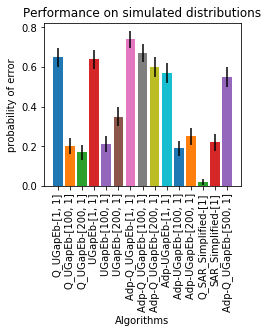

In [14]:
plot_eva(results, 'pe', paper_flag = False)